In [18]:
import math
import time

import torch
import torch.nn as nn
import transformers

from quant import *

import torchvision
import torchvision.transforms as transforms


DEBUG = True 

torch.backends.cuda.matmul.allow_tf32 = False
torch.backends.cudnn.allow_tf32 = False


class SparseGPT:

    def __init__(self, layer):
        self.layer = layer
        self.dev = self.layer.weight.device
        W = layer.weight.data.clone()
        if isinstance(self.layer, nn.Conv2d):
            W = W.flatten(1)
        if isinstance(self.layer, transformers.Conv1D):
            W = W.t()
        self.rows = W.shape[0]
        self.columns = W.shape[1]
        self.H = torch.zeros((self.columns, self.columns), device=self.dev)
        self.nsamples = 0

    def add_batch(self, inp, out, blocksize=1024):
        if DEBUG:
            self.inp1 = inp
            self.out1 = out
        if len(inp.shape) == 2:
            inp = inp.unsqueeze(0)
        tmp = inp.shape[0]
        if isinstance(self.layer, nn.Linear) or isinstance(self.layer, transformers.Conv1D):
            if len(inp.shape) == 3:
                inp = inp.reshape((-1, inp.shape[-1]))
            inp = inp.t()
        self.H *= self.nsamples / (self.nsamples + tmp)
        self.nsamples += tmp
        inp = math.sqrt(2 / self.nsamples) * inp.float()
        self.H += inp.matmul(inp.t())

    def fasterprune(
        self, sparsity, prunen=0, prunem=0, blocksize=128, percdamp=.01
    ):
        W = self.layer.weight.data.clone()
        if isinstance(self.layer, nn.Conv2d):
            W = W.flatten(1)
        if isinstance(self.layer, transformers.Conv1D):
            W = W.t()
        W = W.float()

        if hasattr(self, 'quantizer'):
            if not self.quantizer.ready():
                self.quantizer.find_params(W, weight=True)

        tick = time.time()

        H = self.H
        del self.H
        dead = torch.diag(H) == 0
        H[dead, dead] = 1
        W[:, dead] = 0

        Losses = torch.zeros(self.rows, device=self.dev)

        damp = percdamp * torch.mean(torch.diag(H))
        diag = torch.arange(self.columns, device=self.dev)
        H[diag, diag] += damp
        H = torch.linalg.cholesky(H)
        H = torch.cholesky_inverse(H)
        H = torch.linalg.cholesky(H, upper=True)
        Hinv = H

        mask = None

        for i1 in range(0, self.columns, blocksize):
            i2 = min(i1 + blocksize, self.columns)
            count = i2 - i1

            W1 = W[:, i1:i2].clone()
            Q1 = torch.zeros_like(W1)
            Err1 = torch.zeros_like(W1)
            Losses1 = torch.zeros_like(W1)
            Hinv1 = Hinv[i1:i2, i1:i2]

            if prunen == 0: 
                if mask is not None:
                    mask1 = mask[:, i1:i2]
                else:
                    tmp = W1 ** 2 / (torch.diag(Hinv1).reshape((1, -1))) ** 2
                    thresh = torch.sort(tmp.flatten())[0][int(tmp.numel() * sparsity)]
                    mask1 = tmp <= thresh
            else:
                mask1 = torch.zeros_like(W1) == 1

            for i in range(count):
                w = W1[:, i]
                d = Hinv1[i, i]

                if prunen != 0 and i % prunem == 0:
                    tmp = W1[:, i:(i + prunem)] ** 2 / (torch.diag(Hinv1)[i:(i + prunem)].reshape((1, -1))) ** 2
                    mask1.scatter_(1, i + torch.topk(tmp, prunen, dim=1, largest=False)[1], True)

                q = w.clone()
                q[mask1[:, i]] = 0

                if hasattr(self, 'quantizer'):
                    q = quantize(
                        q.unsqueeze(1), self.quantizer.scale, self.quantizer.zero, self.quantizer.maxq
                    ).flatten()

                Q1[:, i] = q
                Losses1[:, i] = (w - q) ** 2 / d ** 2

                err1 = (w - q) / d
                W1[:, i:] -= err1.unsqueeze(1).matmul(Hinv1[i, i:].unsqueeze(0))
                Err1[:, i] = err1

            W[:, i1:i2] = Q1
            Losses += torch.sum(Losses1, 1) / 2

            W[:, i2:] -= Err1.matmul(Hinv[i1:i2, i2:])

            if DEBUG:
                self.layer.weight.data[:, :i2] = W[:, :i2]
                self.layer.weight.data[:, i2:] = W[:, i2:]
                print("error norm", torch.sum((self.layer(self.inp1) - self.out1) ** 2))
                # print(torch.sum(Losses))

        torch.cuda.synchronize()
        print('time %.2f' % (time.time() - tick))
        print('error', torch.sum(Losses).item())

        if isinstance(self.layer, transformers.Conv1D):
            W = W.t()
        self.layer.weight.data = W.reshape(self.layer.weight.shape).to(self.layer.weight.data.dtype)
        if DEBUG:
            print(torch.sum((self.layer(self.inp1) - self.out1) ** 2))

    def free(self):
        if DEBUG:
            self.inp1 = None
            self.out1 = None
        self.H = None
        torch.cuda.empty_cache()




In [46]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [21]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [26]:
import torch.optim as optim

def train_model(model, trainloader, epochs = 4):

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

In [27]:
def validate_model(model, testloader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct // total

In [7]:
# # prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # again no gradients needed
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         outputs = net(images)
#         _, predictions = torch.max(outputs, 1)
#         # collect the correct predictions for each class
#         for label, prediction in zip(labels, predictions):
#             if label == prediction:
#                 correct_pred[classes[label]] += 1
#             total_pred[classes[label]] += 1


# # print accuracy for each class
# for classname, correct_count in correct_pred.items():
#     accuracy = 100 * float(correct_count) / total_pred[classname]
#     print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 49.7 %
Accuracy for class: car   is 59.4 %
Accuracy for class: bird  is 51.3 %
Accuracy for class: cat   is 44.9 %
Accuracy for class: deer  is 51.0 %
Accuracy for class: dog   is 26.3 %
Accuracy for class: frog  is 74.5 %
Accuracy for class: horse is 55.7 %
Accuracy for class: ship  is 73.0 %
Accuracy for class: truck is 59.1 %


In [34]:
def pruneLayers(model, trainloader, sparsity=0.5, blocksize=56):
    batch, _ = next(iter(trainloader))
    inp1 = model.pool(F.relu(model.conv1(batch)))
    inp1 = model.pool(F.relu(model.conv2(inp1)))
    inp1 = torch.flatten(inp1, 1) 
    out1 = model.fc1(inp1)
    
    sparseLayer1 = SparseGPT(model.fc1)
    sparseLayer1.add_batch(inp1, out1)
    sparseLayer1.fasterprune(sparsity, blocksize=blocksize)
    
    inp2 = F.relu(out1)
    out2 = model.fc2(inp2)
    sparseLayer2 = SparseGPT(model.fc2)
    sparseLayer2.add_batch(inp2, out2)
    sparseLayer2.fasterprune(sparsity, blocksize=blocksize)

    inp3 = F.relu(out2)
    out3 = model.fc3(inp3)
    sparseLayer3 = SparseGPT(model.fc3)
    sparseLayer3.add_batch(inp3, out3)
    sparseLayer3.fasterprune(sparsity, blocksize=blocksize)
       

In [47]:
denseModel = Net()
train_model(denseModel, trainloader)

Finished Training


In [48]:
import copy
modelAccuracy = [validate_model(denseModel, testloader)]

for sparsity in range(1,10):
    sparseModel = copy.deepcopy(denseModel)
    pruneLayers(sparseModel, trainloader, sparsity/10)
    modelAccuracy.append(validate_model(sparseModel, testloader))


error norm tensor(1.4551e-05, grad_fn=<SumBackward0>)
error norm tensor(4.1059e-05, grad_fn=<SumBackward0>)
error norm tensor(8.6534e-05, grad_fn=<SumBackward0>)
error norm tensor(0.0002, grad_fn=<SumBackward0>)
error norm tensor(0.0003, grad_fn=<SumBackward0>)
error norm tensor(0.0005, grad_fn=<SumBackward0>)
error norm tensor(0.0128, grad_fn=<SumBackward0>)
error norm tensor(0.0271, grad_fn=<SumBackward0>)
time 0.11
error 0.09782558679580688
tensor(0.0271, grad_fn=<SumBackward0>)
error norm tensor(0., grad_fn=<SumBackward0>)
error norm tensor(0., grad_fn=<SumBackward0>)
error norm tensor(0., grad_fn=<SumBackward0>)
time 0.03
error 0.0
tensor(0., grad_fn=<SumBackward0>)
error norm tensor(9.6443e-06, grad_fn=<SumBackward0>)
error norm tensor(2.6978e-05, grad_fn=<SumBackward0>)
time 0.02
error 0.00015530409291386604
tensor(2.6978e-05, grad_fn=<SumBackward0>)
error norm tensor(9.5930e-05, grad_fn=<SumBackward0>)
error norm tensor(0.0003, grad_fn=<SumBackward0>)
error norm tensor(0.0006, 

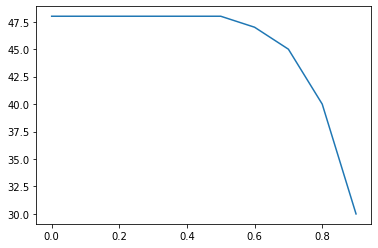

In [49]:
import matplotlib.pyplot as plt

plt.plot([x/10 for x in range(0,10)], modelAccuracy)

In [50]:
sparsity1 = sparseModel.fc1.weight.data[sparseModel.fc1.weight.data == 0].shape[0] / (sparseModel.fc1.weight.data.shape[0] * sparseModel.fc1.weight.data.shape[1]) 
sparsity2 = sparseModel.fc2.weight.data[sparseModel.fc2.weight.data == 0].shape[0] / (sparseModel.fc2.weight.data.shape[0] * sparseModel.fc2.weight.data.shape[1]) 
sparsity3 = sparseModel.fc3.weight.data[sparseModel.fc3.weight.data == 0].shape[0] / (sparseModel.fc3.weight.data.shape[0] * sparseModel.fc3.weight.data.shape[1]) 
sparsity1, sparsity2, sparsity3

(0.9001666666666667, 0.9000992063492064, 0.9023809523809524)

In [51]:
sparseModel.fc3.weight.data

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000, -0.1566,  0.0000,  0.0000,  0.1963,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.2323,  0.4301, -0.1493,
          0.0000,  0.0000, -0.2193,  0.0000,  0.0000,  0.0000,  0.5497,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000, -0.6138,  0.0000,  0.0000,  0.0000,  0.3898,
          0.0000,  0.0000,  0.0000, -0.1234],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, 